# TUIA / AAII - TP2: Redes Recurrentes y Transformers - Problema 1

> *Modelo de Clasificación para inferir el dígito correspondiente a un clip de audio.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [ ]:
# Importar desde Google Drive
# !pip install -q gdown

In [1]:
pip install hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82

In [17]:
# Datasets
# import gdown
# import zipfile

# Data
import os
import pathlib
import numpy as np
import hub
# import pandas as pd
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# Visualizaciones
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython import display
# from plotly.subplots import make_subplots
# import plotly.graph_objs as go
import seaborn as sns

# ML metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
# from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
# from tensorflow.keras.models import Sequential, load_model, save_model
# from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import layers, models

# Semillas para reproductibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### GPU

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Dataset

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor

https://www.tensorflow.org/datasets/catalog/spoken_digit

### Descarga

In [8]:
ds = hub.load("hub://activeloop/spoken_mnist")

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



-

hub://activeloop/spoken_mnist loaded successfully.



In [9]:
ds.visualize()

## Análisis Exploratorio

In [19]:
ds

Dataset(path='hub://activeloop/spoken_mnist', read_only=True, tensors=['spectrograms', 'labels', 'audio', 'speakers'])

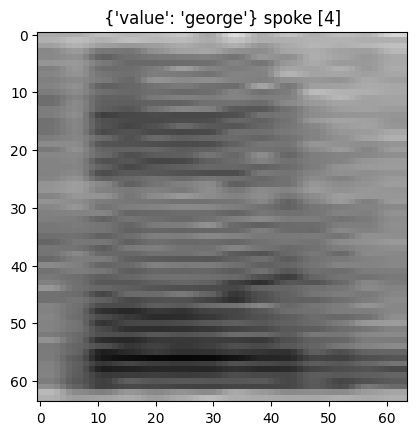

In [16]:
# check out the first spectrogram, it's label, and who spoke it!
index = 1234
plt.imshow(ds.spectrograms[index].numpy())
plt.title(f"{ds.speakers[index].data()} spoke {ds.labels[index].numpy()}")
plt.show()

## Conjuntos de Train y Test

## Visualizaciones

# CNN / Clasificación

## Modelo

### Definición y entrenamiento

In [ ]:
# Definición del Modelo
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

In [ ]:
# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 30
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)
print("-------------------------\nFin del Entrenamiento")

### Visualización de Métricas

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Predicciones

In [ ]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inferencia

Inferimos sobre un archivo de audio (en este caso tomamos un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Observaciones finales

Puede concluirse que para la resolución de este problema, el dataset provisto entrega unos datos muy generosos, tanto en el comportamiento de las variables como en la distribución de las mismas.

El modelo de red neuronal densa para este problema de regresión logra unos resultados excelentes sin demasiado esfuerzo ni complejidad en la arquitectura.